In [1]:
%load_ext autoreload
%autoreload 2

# Cargo Bike Parking Distance Analysis


In [2]:
import os
import sys
from pathlib import Path

# add the
ROOT = Path(os.getcwd())
while not (ROOT / ".git").exists():
    ROOT = ROOT.parent

sys.path.append(str(ROOT))

from src.config import CargoBikeConfig, load_config
from src.osm_tags import build_tag_filter


import polars as pl
import geopolars as gpl
import geopandas as gpd
import pandas as pd

## Load Config


In [3]:
config = load_config(ROOT / "config" / "paper.yaml")

In [4]:
h3_df = pd.concat(
    [gpd.read_parquet(city.h3_file).assign(city=city.name) for city in config.Cities],
    axis=0,
).query("is_city")

h3_df = h3_df.merge(
    pd.read_parquet(ROOT / "data/geovex/clusters_4.parquet").drop("city", axis=1),
    on="region_id",
)

h3_df.head()

,region_id,geometry,is_city,city,cluster
0,892a339a5afffff,"POLYGON ((-71.13572 42.23376, -71.13794 42.232...",True,"Boston, USA",0
1,892a3066a3bffff,"POLYGON ((-71.08114 42.30902, -71.08337 42.308...",True,"Boston, USA",0
2,892a3066e17ffff,"POLYGON ((-71.06072 42.33323, -71.06295 42.332...",True,"Boston, USA",3
3,892a3066b3bffff,"POLYGON ((-71.06614 42.29023, -71.06837 42.289...",True,"Boston, USA",0
4,892a3066803ffff,"POLYGON ((-71.05014 42.31442, -71.05236 42.313...",True,"Boston, USA",0


In [5]:
parking_df = pl.concat(
    [
        pl.read_parquet(city.file).select(["region_id", "parking_distance"])
        for city in config.ServiceTime
        if "amazon" not in city.name
    ],
)

# this does two things, one adds the city label and 2, it crops to the city limits
parking_df = parking_df.join(
    pl.DataFrame(h3_df.reset_index()[["region_id", "city", "cluster"]]),
    on="region_id",
    how="inner",
)

parking_df.head()

region_id,parking_distance,city,cluster
str,f64,str,i64
"""891fa441b53fff…",7.249446,"""Brussels, Belg…",1
"""891fa441bdbfff…",7.508782,"""Brussels, Belg…",1
"""891fa441b83fff…",20.423592,"""Brussels, Belg…",1
"""891fa44194ffff…",98.845455,"""Brussels, Belg…",1
"""891fa4419b3fff…",44.251486,"""Brussels, Belg…",1


## looking at tails

In [9]:
# check how many % of deliveries are longer than 100m in brussels and london in the polars dataframe
parking_df.filter(pl.col("city") == 'london').filter(pl.col("parking_distance") > 100).shape[
    0
] / parking_df.filter(pl.col("city") == 'london').shape[0]

ColumnNotFoundError: city == 'london'

## Group the Parking Distance by City


In [6]:
print(
    parking_df.group_by("city")
    .agg(
        pl.count(),
        pl.col("parking_distance").mean().alias("mean_parking_distance"),
        pl.col("parking_distance").std().alias("std_parking_distance"),
        pl.col("parking_distance").quantile(0.1).alias("parking_distance_10"),
        pl.col("parking_distance").quantile(0.5).alias("parking_distance_50"),
        pl.col("parking_distance").quantile(0.9).alias("parking_distance_90"),
        pl.col("parking_distance").max().alias("parking_distance"),
    )
    .sort("city")
    .with_columns(pl.col("city").str.split(", ").list.get(1).alias("country"))
    .sort(["country", "city"])
    .drop("country")
    .to_pandas()
    .round(1)
    .to_latex(
        float_format="%.1f",
        index=False,
    )
)

\begin{tabular}{lrrrrrrr}
\toprule
city & count & mean_parking_distance & std_parking_distance & parking_distance_10 & parking_distance_50 & parking_distance_90 & parking_distance \\
\midrule
Brussels, Belgium & 12071 & 31.5 & 31.2 & 10.1 & 22.1 & 61.4 & 250.2 \\
London, UK & 9592 & 29.1 & 25.2 & 10.3 & 21.4 & 60.5 & 749.8 \\
\bottomrule
\end{tabular}



### Statistical Tests


In [7]:
from scipy.stats import mannwhitneyu


res = mannwhitneyu(
    parking_df.filter(pl.col("city").str.contains("Brussels"))["parking_distance"],
    parking_df.filter(pl.col("city").str.contains("London"))["parking_distance"],
    alternative="two-sided",
)


# science format the statistic
print(f"$U={res.statistic:.0f}, p < {res.pvalue:.2f}$")

$U=58988046, p < 0.02$


## Compare Clusters


In [8]:
from scikit_posthocs import posthoc_conover, sign_plot
from scipy.stats import kruskal


def get_posthoc_score(
    city, parking_distance="parking_distance", cluster_col="cluster", p_adjust="holm"
):
    city_df = parking_df.filter(pl.col("city").str.contains(city))
    # ordering = (
    #     city_df.group_by("cluster")
    #     .agg(pl.col(service_time_col).mean())
    #     .sort(service_time_col, descending=True)
    # )
    # ordering = ordering[cluster_col].to_list()

    # create a dataframe with the cluster and the service time
    df = city_df[[cluster_col, parking_distance]].to_pandas()

    # run the posthocs test
    return posthoc_conover(
        df, val_col=parking_distance, group_col=cluster_col, p_adjust=p_adjust
    ), kruskal(*(_df[parking_distance].values for _, _df in df.groupby(cluster_col)))

KruskalResult(statistic=15.371067152454682, pvalue=0.0015254975529590486)


,0,1,2,3
0,1.000,0.258,0.001,0.166
1,0.258,1.000,0.003,0.296
2,0.001,0.003,1.000,0.039
3,0.166,0.296,0.039,1.000


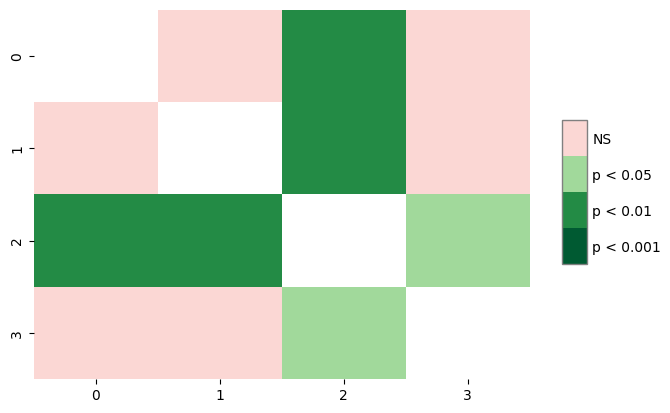

In [11]:
durbin_res, kruskal_res = get_posthoc_score("Brussels")

sign_plot(
    durbin_res,
)

print(kruskal_res)
durbin_res.round(3)

In [14]:
# print(
(
    parking_df.group_by("city", "cluster")
    .agg(
        pl.count(),
        pl.col("parking_distance").mean().alias("mean_parking_distance"),
        pl.col("parking_distance").std().alias("std_parking_distance"),
        pl.col("parking_distance").quantile(0.1).alias("parking_distance_10"),
        pl.col("parking_distance").quantile(0.5).alias("parking_distance_50"),
        pl.col("parking_distance").quantile(0.9).alias("parking_distance_90"),
        pl.col("parking_distance").max().alias("parking_distance"),
    )
    .sort("city")
    .with_columns(pl.col("city").str.split(", ").list.get(1).alias("country"))
    .sort(["country", "city"])
    .drop("country")
    .to_pandas()
    .round(1)
)
# .to_latex(
#     float_format="%.1f",
#     index=False,
# )

,city,cluster,count,mean_parking_distance,std_parking_distance,parking_distance_10,parking_distance_50,parking_distance_90,parking_distance
0,"Brussels, Belgium",2,381,38.0,36.6,11.9,24.4,102.0,220.0
1,"Brussels, Belgium",1,9707,31.4,31.0,9.9,22.1,61.9,250.1
2,"Brussels, Belgium",3,1433,30.5,29.1,11.3,22.5,55.1,242.7
3,"Brussels, Belgium",0,550,31.0,34.4,11.3,20.9,57.8,250.2
4,"London, UK",2,937,23.8,17.1,9.4,19.1,46.0,122.9
5,"London, UK",1,4208,27.5,26.0,9.7,20.0,55.6,749.8
6,"London, UK",0,3693,33.2,26.6,11.2,24.9,69.3,742.5
7,"London, UK",3,754,24.6,18.3,10.9,19.0,44.2,130.2


KruskalResult(statistic=282.82401884458875, pvalue=5.185257654225412e-61)


,0,1,2,3
0,1.0,0.000,0.000,0.000
1,0.0,1.000,0.002,0.068
2,0.0,0.002,1.000,0.423
3,0.0,0.068,0.423,1.000


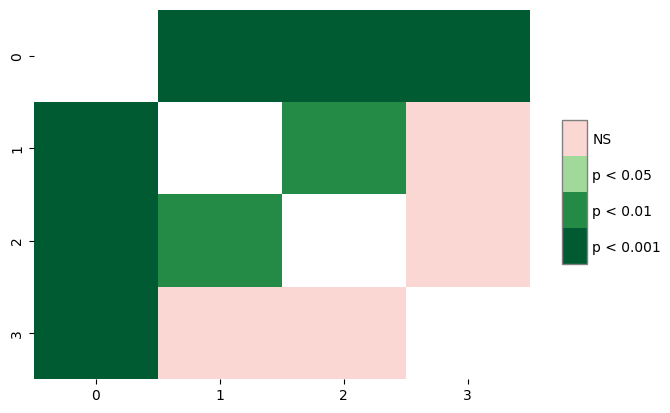

In [12]:
durbin_res, kruskal_res = get_posthoc_score("London")

sign_plot(
    durbin_res,
)

print(kruskal_res)
durbin_res.round(3)